c:\Users\marce\OneDrive\Documents\BathLife\Y3\RL\CS1\.venv\Lib\site-packages\pygame\pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


(4, 128, 64)
0.8577777777777779
False
False
{'speed': 25.500000000000004, 'crashed': False, 'action': [0.5, 0.0], 'rewards': {'collision_reward': 0.0, 'right_lane_reward': 0.6666666666666666, 'high_speed_reward': np.float64(0.5500000000000004), 'on_road_reward': 1.0}}


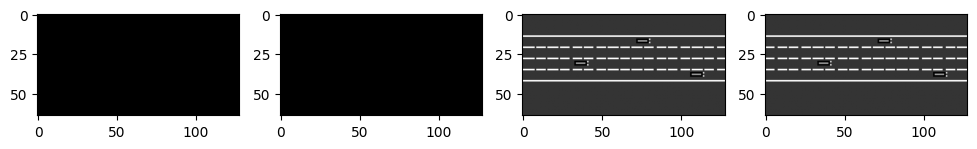

In [2]:
import gymnasium as gym
import highway_env
import matplotlib.pyplot as plt
import torch

import numpy as np

config = {
    "observation": {
        "type": "GrayscaleObservation",
        "observation_shape": (128, 64),
        "stack_size": 4,
        "weights": [0.2989, 0.5870, 0.1140],
        "scaling": 1.75,
    },
    "action": {
        "type": "ContinuousAction",
        "longitudinal": True,
        "lateral": True,
        # LIMIT STEERING to ~10 degrees (0.2 radians)
        # Default is 45 degrees (0.78 rad) which is suicide at high speeds
        "steering_range": [-0.2, 0.2]  
    },
    # CRITICAL: Make decisions 15 times a second, not once a second!
    "simulation_frequency": 15,
    "policy_frequency": 5, 
    "duration": 40, # Episode length in seconds,
    "offroad_terminal": True
}

env = gym.make('highway-v0', config=config, render_mode='rgb_array')
obs, info = env.reset()
action = [0.5, 0.0]

for _ in range(1):
    obs, reward, done, truncated, info = env.step(action)

    print(obs.shape)
    print(reward)
    print(done)
    print(truncated)
    print(info)

    fig, axes = plt.subplots(ncols=4, figsize=(12, 5))
    for i, ax in enumerate(axes.flat):
        ax.imshow(obs[i, ...].T, cmap=plt.get_cmap('gray'))
plt.show()

In [3]:
from SAC import SAC

# Create a dummy agent
agent = SAC(env, state_size=4)

# Create a fake input batch: 32 images of size 4x128x64
fake_state = torch.randn(32, 4, 128, 64)
fake_action = torch.randn(32, 2)

# 1. Test Actor
print("Testing Actor...")
mu, log_std = agent.actor(fake_state)
print(f"Actor Output Shape: {mu.shape}") # Should be (32, 2)

# 2. Test Critic
print("Testing Critic...")
# Remember Critic takes (State + Action)
q_val = agent.critic_1(fake_state, fake_action) 
print(f"Critic Output Shape: {q_val.shape}") # Should be (32, 1)

print("Dimensions look good!")

Testing Actor...
Actor Output Shape: torch.Size([32, 2])
Testing Critic...
Critic Output Shape: torch.Size([32, 1])
Dimensions look good!


In [ ]:
# Main Loop Test
episodes = 100

for _ in range(0, episodes):
    agent.collect_data() # Collect 1 episode
    print(f"Buffer Size: {len(agent.replayBuffer)}") # Should be > 0
    agent.learn(batch_size=16) # Small batch for testing
    print("Learn step complete.")

Buffer Size: 113
Learn step complete.
Buffer Size: 128
Learn step complete.
Buffer Size: 137
Learn step complete.
Buffer Size: 140
Learn step complete.
Buffer Size: 157
Learn step complete.
Buffer Size: 164
Learn step complete.
Buffer Size: 179
Learn step complete.
Buffer Size: 200
Learn step complete.
Buffer Size: 238
Learn step complete.
Buffer Size: 248
Learn step complete.
Buffer Size: 255
Learn step complete.
Buffer Size: 266
Learn step complete.
Buffer Size: 277
Learn step complete.
Buffer Size: 293
Learn step complete.
Buffer Size: 295
Learn step complete.
Buffer Size: 302
Learn step complete.
Buffer Size: 317
Learn step complete.
Buffer Size: 331
Learn step complete.
Buffer Size: 337
Learn step complete.
Buffer Size: 340
Learn step complete.
Buffer Size: 354
Learn step complete.
Buffer Size: 377
Learn step complete.
Buffer Size: 396
Learn step complete.
Buffer Size: 410
Learn step complete.
Buffer Size: 433
Learn step complete.
Buffer Size: 442
Learn step complete.
Buffer Size:

: 

In [4]:
NUM_EPISODES = 10
total_rewards = []


for episode in range(NUM_EPISODES):
  print(f"Episode {episode}")
  done = truncated = False

  obs, info = env.reset()
  
  while not (done or truncated):
    action = agent.choose_action_numpy(obs)

    next_obs, reward, done, truncated, info = env.step(action)
    print(info)
    obs=next_obs
    env.render()

Episode 0
{'speed': 25.927532577514647, 'crashed': False, 'action': array([0.9275327, 0.7339436], dtype=float32), 'rewards': {'collision_reward': 0.0, 'right_lane_reward': 0.0, 'high_speed_reward': np.float64(0.5639203039025826), 'on_road_reward': 1.0}}
{'speed': 26.082530021667484, 'crashed': False, 'action': array([ 0.15499751, -0.13918905], dtype=float32), 'rewards': {'collision_reward': 0.0, 'right_lane_reward': 0.0, 'high_speed_reward': np.float64(0.5893896339279934), 'on_road_reward': 1.0}}
{'speed': 25.229208374023436, 'crashed': False, 'action': array([-0.8533216 , -0.50675154], dtype=float32), 'rewards': {'collision_reward': 0.0, 'right_lane_reward': 0.0, 'high_speed_reward': np.float64(0.522616580729234), 'on_road_reward': 1.0}}
{'speed': 26.099129486083978, 'crashed': False, 'action': array([ 0.86992115, -0.5153348 ], dtype=float32), 'rewards': {'collision_reward': 0.0, 'right_lane_reward': 0.0, 'high_speed_reward': np.float64(0.5993710327462842), 'on_road_reward': 1.0}}
{'s